# Twitter trolls exploratory analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from IPython.display import display
from utils import load_data, histogram_summary, frequency_histogram

In [2]:
sns.set_style('white')
pd.set_option('display.float_format', "{:.3f}".format)
plt.rcParams['figure.figsize'] = 12,5

DATA_FILE = "data/english.csv"

In [3]:
df = load_data(DATA_FILE, sample=True, size=1000)

50000 rows x 31 cols
Loaded in 0.39s
Cleaning ops done in 1.12s


### Missing values

 - Lots of missing values here. 
 - Unfortunately, latitude and longitude are not usable, nor are poll choices, whatever it means. 
 - Might be interesting to dig into user_reported_location. 
 - Most user profile url are missing as well, for some reason. Urls are mostly there. Maybe some crawling to do if necessary.
 - The remaining columns with missing values (in_reply, quoted_tweet, retweet, user_mentions, hashtags) probably indicate False when the value is missing.

In [4]:
# Just check what is actually usable here and what we need to drop
df.isnull().mean(axis=0).sort_values(ascending=False).map("{:.2%}".format).rename('missing values')

longitude                   100.00%
latitude                    100.00%
poll_choices                 99.99%
in_reply_to_tweetid          98.04%
in_reply_to_userid           97.02%
quoted_tweet_tweetid         96.03%
user_profile_url             82.44%
retweet_userid               66.90%
retweet_tweetid              66.90%
user_mentions                60.57%
urls                         13.86%
user_profile_description     11.16%
user_reported_location       10.11%
hashtags                      9.18%
quote_count                   0.04%
reply_count                   0.04%
like_count                    0.04%
retweet_count                 0.04%
tweet_client_name             0.00%
userid                        0.00%
user_display_name             0.00%
user_screen_name              0.00%
tweet_text                    0.00%
follower_count                0.00%
following_count               0.00%
account_creation_date         0.00%
account_language              0.00%
tweet_language              

### Tweet timing

Idea: identify periods (clusters) for which tweets often occur. 

To do that, try to cluster using different sampling periods and select the best clusters. Check whether it makes sense to learn periods in bots tweets

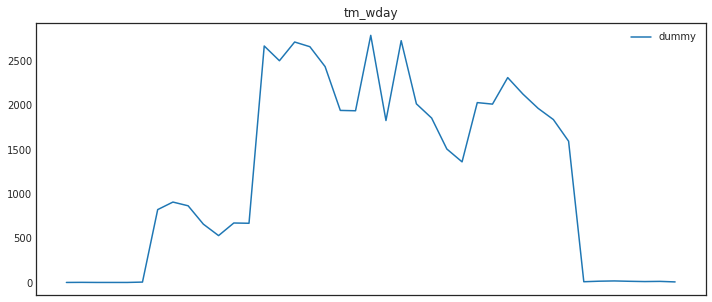

In [46]:
def infer_periods(timeseries):
    # time_series is a pandas dataframe with a datetime index
    columns = ["tm_year", "tm_mon", "tm_mday", 
               "tm_hour", "tm_wday", "tm_yday"]
    
    def _infer_period(ts): 
        tup = ts.timetuple()
        return tuple([getattr(tup, attr) for attr in columns])
        
    index = pd.Series(timeseries.index, name="timestamp")
    return pd.DataFrame(index.apply(_infer_period).tolist(), columns=columns, index=index)

def period_histogram(df, sampling, aggregate_over_year=False, kind='bar'):
    periods = infer_periods(df).copy()
    periods["dummy"] = 1
    if not aggregate_over_year and sampling != "tm_year":
        sampling = ["tm_year", sampling]
    else:
        sampling = [sampling]
    summary = periods.groupby(sampling).count()[["dummy"]]
    ax = summary.plot(kind=kind)
#     years, days = list(zip(*list(summary.index)))
    ax.set_xlabel(""); ax.set_title(sampling[-1])
    
    
period_histogram(df, "tm_wday", aggregate_over_year=False, kind='line')

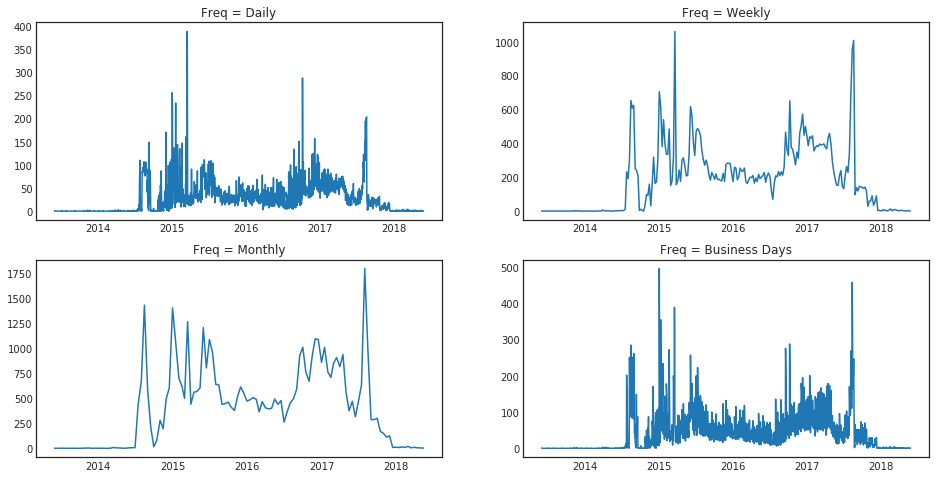

In [50]:
# Resample on frequency and plot the histogram

frequencies = ["Daily", "Weekly", "Monthly", "Business Days"]

fig, axs = plt.subplots(2,2)
summary = pd.DataFrame()
for ax, freq in zip([ax for axr in axs for ax in axr], frequencies):
    sampling = freq[0] if freq[0] != 'M' else 'SM'
    df_freq = df[['tweetid']].resample(sampling).count()  #.compute()
    ax.plot(df_freq.index, df_freq.tweetid)
    ax.set_title(f"Freq = {freq}");
    descr = df_freq.describe()
    summary[freq] = descr.values[:, 0]
summary.set_index(descr.index, inplace=True)
ax.get_figure().set_size_inches((16,8))

plt.savefig("images/timeline.png")

### Users

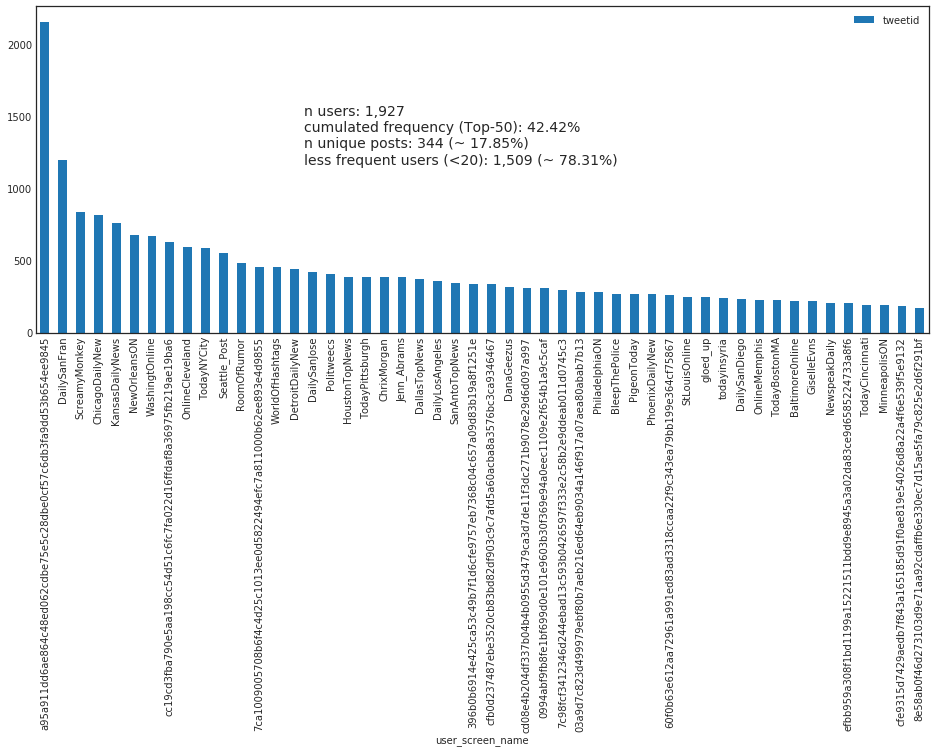

In [6]:
counts_by_users = (df[["user_screen_name", "tweetid"]]
                   .groupby("user_screen_name")
                   .count()
                   .sort_values("tweetid", ascending=False))

k, thres = 50, 20
nunique_posts = len(counts_by_users.loc[counts_by_users["tweetid"] <= 1])
less_frequent = len(counts_by_users.loc[counts_by_users["tweetid"] <= thres])
top_users = counts_by_users.head(k)
ax = top_users.plot.bar()

histogram_summary(ax, .6, .7, {
    "n users": f"{len(counts_by_users):,}",
    f'cumulated frequency (Top-{k})': f"{(top_users.sum() / counts_by_users.sum()).values[0]:.2%}",
    f"n unique posts": f"{nunique_posts:,} (~ {nunique_posts / len(counts_by_users):.2%})",
    f"less frequent users (<{thres})": f"{less_frequent:,} (~ {less_frequent / len(counts_by_users):.2%})"
    
})

## Tweet text

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline

### Count Vectorizer

<div style="color: red">Text Instance (m x 1) --> Word Counts (m x n), n = size of vocabulary</div>

In [8]:
# Whole dataset
# data = load_data(DATA_FILE, sample=False)
# X = data['tweet_text'].values.compute()
X = df["tweet_text"].values

In [9]:
vect = CountVectorizer()
X_vect = vect.fit_transform(X)

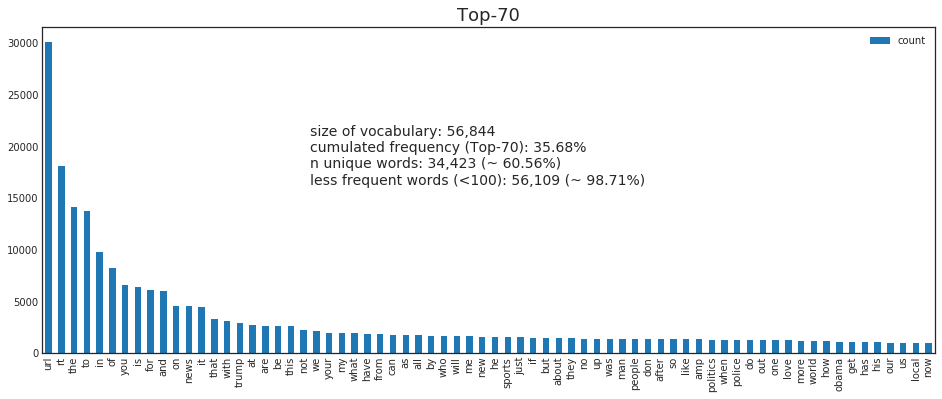

In [10]:
cnts = frequency_histogram(X_vect, vect.get_feature_names(), 70)

Select only 10,000 most frequent words

In [18]:
n_to_keep = 10000
words_to_keep = list(cnts.iloc[:n_to_keep, :].index)
idx_to_keep = sorted([v for k, v in vect.vocabulary_.items() if k in to_keep])
X_top10k = X_vect[:, idx_to_keep]

<50000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 526156 stored elements in Compressed Sparse Row format>

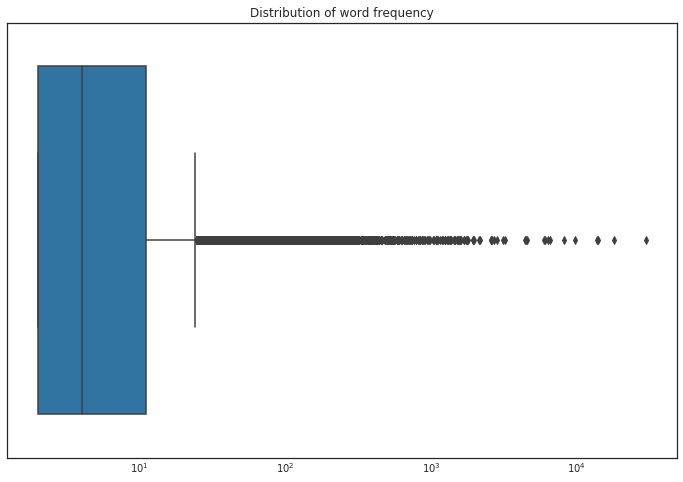

In [21]:
sns.boxplot(cnts[cnts["count"] > 1])
plt.gca().set_xscale('log')
plt.title("Distribution of word frequency");
# cnts.loc[cnts["count"] > 1, "count"].apply(np.log10).plot.hist();

### Tf-Idf Vectorizer

<div style="color: red">Same distribution as for the count vectorizer but might give better results for classification purposes</div>

In [ ]:
# tfidf = TfidfVectorizer()
# X_tfidf = tfidf.fit_transform(X)
# frequency_histogram(X_tfidf, vect.get_feature_names(), thres=1e-4, aggfunc=np.mean);

### Single Value Decomposition

<div style="color: red">Useless at the moment, I was trying to find some nice visualisation proving that features might be (linearly) separable but no luck there at the moment...</div>

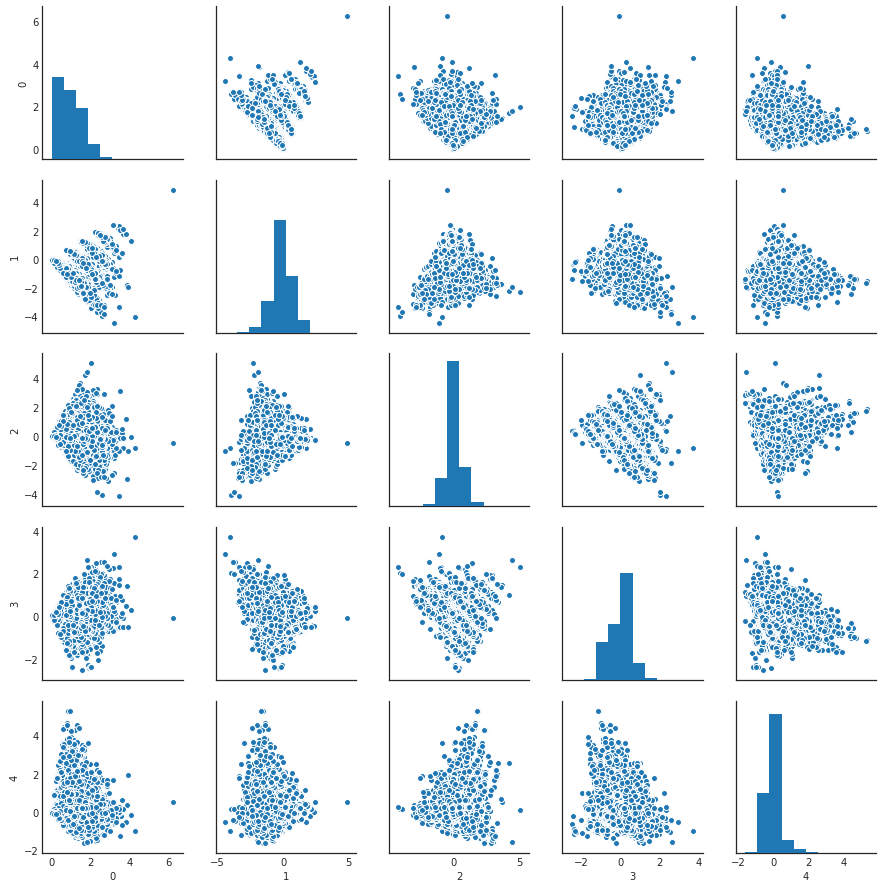

In [23]:
svd = TruncatedSVD(n_components=5)
X_svd = svd.fit_transform(X_vect)
sns.pairplot(pd.DataFrame(X_svd));

In [26]:
X[13013]
# TODO: Is the URL pattern catching all and only URL??

'RT @ausecure: Streaming #Gold $%URL% +$%URL% #Silver $%URL% +$%URL% #Platinum $%URL% +$%URL% #Palladium $%URL% +$%URL%'

## Pipeline


<div style="color: red">Chaining operations all together</div>

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=5)),
    ('cluster', KMeans(n_clusters=8)),
#     ('clf', SVC())
])

In [ ]:
X_cluster = pipe.fit_transform(X)

## Grid Search

<div style="color: red">Search hyperparameter space</div>

In [ ]:
params_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'pca__n_components': [2, 5, 8],
#     'clf__alpha': (1e-2, 1e-3),
}